# Query-by-Example (QbE) Search Using DTW

## Preliminary

In [12]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
from __future__ import division
from __future__ import print_function
from os import path
from python_speech_features import delta
from python_speech_features import mfcc
import glob
import matplotlib.pyplot as plt
import numpy as np
import scipy.io.wavfile as wav
import sys
from pydub import AudioSegment
from pydub.playback import play

sys.path.append("utils")

from speech_dtw import qbe

## Extract features

In [14]:
def get_mfcc_dd(wav_fn, cmvn=True):
    """Return the MFCCs with deltas and delta-deltas for a audio file."""
    (rate, signal) = wav.read(wav_fn)
    mfcc_static = mfcc(signal, rate, nfft=1103)
    mfcc_deltas = delta(mfcc_static, 2)
    mfcc_delta_deltas = delta(mfcc_deltas, 2)
    features = np.hstack([mfcc_static, mfcc_deltas, mfcc_delta_deltas])
    if cmvn:
        features = (features - np.mean(features, axis=0)) / np.std(features, axis=0)
    return features

In [19]:
audio = 'taiwanese'
wav_fn = path.join(audio, "word_daiwan.wav")
print("Reading:", wav_fn)
query_mfcc = get_mfcc_dd(wav_fn)
query_wav = AudioSegment.from_file(wav_fn, format="wav")
original_mfcc_list = []
original_wav = []
for wav_fn in sorted(glob.glob(path.join(audio, "original?.wav"))):
    print("Reading:", wav_fn)
    #original_wav.append(sa.WaveObject.from_wave_file(wav_fn))
    original_wav.append(AudioSegment.from_file(wav_fn, format="wav"))
    original_mfcc_list.append(get_mfcc_dd(wav_fn))
respeak_mfcc_list = []
respeak_wav = []
for wav_fn in sorted(glob.glob(path.join(audio, "respeak?.wav"))):
    print("Reading:", wav_fn)
    #respeak_wav.append(sa.WaveObject.from_wave_file(wav_fn))
    respeak_wav.append(AudioSegment.from_file(wav_fn, format="wav"))
    respeak_mfcc_list.append(get_mfcc_dd(wav_fn))

Reading: taiwanese/word_daiwan.wav
Reading: taiwanese/original1.wav
Reading: taiwanese/original2.wav
Reading: taiwanese/original3.wav
Reading: taiwanese/respeak1.wav
Reading: taiwanese/respeak2.wav
Reading: taiwanese/respeak3.wav


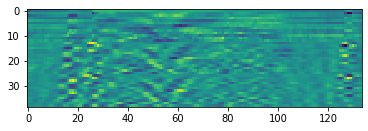

In [16]:
# Plot query
plt.imshow(query_mfcc.T, interpolation="nearest")

## Intermediate analysis

Align query to a search utterance from the same speaker containing the keyword.

In [20]:
print('Started')
sweep_original = qbe.dtw_sweep(query_mfcc, original_mfcc_list[1])
#plt.plot(sweep_original,color='green')
sweep_respeak = qbe.dtw_sweep(query_mfcc, respeak_mfcc_list[1])
#plt.plot(sweep_respeak,color='blue')
#print(len(query_mfcc))
print('Min distance:')

#print(len(original_wav[1]))
#print(len(original_mfcc_list[1]))
#print(len(sweep_original))

print('Original ' + str(min(sweep_original)))

#min_original = np.argmin(sweep_original)
#print(min_original)
#print(len(respeak_mfcc_list[1])-len(query_mfcc))
#print(len(sweep_respeak))

print('Respeak ' + str(min(sweep_respeak)))

#print(np.argmin(sweep_respeak))
#print(len(respeak_mfcc_list[1]))
min_respeak = 30*(np.argmin(sweep_respeak))
#print(min_respeak)
#print(len(sweep_respeak))
word_respeak = respeak_wav[1][min_respeak:min_respeak+(5*len(query_mfcc))]
play(query_wav)
play(respeak_wav[1])
#play(word_respeak)
#print(len(query_wav))
#print(len(word_respeak))
#query_wav.play().wait_done()
#original_wav[1].play().wait_done()
#respeak_wav[1].play().wait_done()
#original_word = original_wav[1][]
plt.show()

Started
<MemoryView of 'ndarray' object>
<MemoryView of 'ndarray' object>
<MemoryView of 'ndarray' object>
<MemoryView of 'ndarray' object>
<MemoryView of 'ndarray' object>
<MemoryView of 'ndarray' object>
<MemoryView of 'ndarray' object>
<MemoryView of 'ndarray' object>
<MemoryView of 'ndarray' object>
<MemoryView of 'ndarray' object>
<MemoryView of 'ndarray' object>
<MemoryView of 'ndarray' object>
<MemoryView of 'ndarray' object>
<MemoryView of 'ndarray' object>
<MemoryView of 'ndarray' object>
<MemoryView of 'ndarray' object>
<MemoryView of 'ndarray' object>
<MemoryView of 'ndarray' object>
<MemoryView of 'ndarray' object>
<MemoryView of 'ndarray' object>
<MemoryView of 'ndarray' object>
<MemoryView of 'ndarray' object>
<MemoryView of 'ndarray' object>
<MemoryView of 'ndarray' object>
<MemoryView of 'ndarray' object>
<MemoryView of 'ndarray' object>
<MemoryView of 'ndarray' object>
<MemoryView of 'ndarray' object>
<MemoryView of 'ndarray' object>
<MemoryView of 'ndarray' object>
<M

KeyboardInterrupt: 

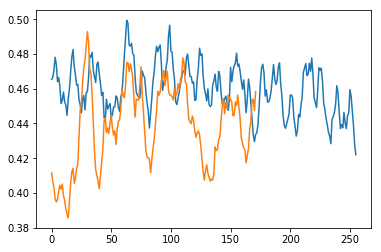

In [7]:
sweep_original = qbe.dtw_sweep(query_mfcc, original_mfcc_list[0])
plt.plot(sweep_original)
sweep_respeak = qbe.dtw_sweep(query_mfcc, respeak_mfcc_list[0])
plt.plot(sweep_respeak)

The minimum aligns with the occurrence of the keyword.

## QbE experiments

Of the four utterances in the search collection, only the utterance `wav/search3.wav` does not contain the keyword. This element corresponds to `search_mfcc_list[2]`.

In [8]:
n_cpus = 3
dtw_costs_original =qbe.parallel_dtw_sweep_min([query_mfcc], original_mfcc_list, n_cpus=n_cpus)
print("DTW costs over original collection:", dtw_costs_original[0])
dtw_costs_respeak = qbe.parallel_dtw_sweep_min([query_mfcc], respeak_mfcc_list, n_cpus=n_cpus)
print("DTW costs over respoken collection:", dtw_costs_respeak[0])

DTW costs over original collection: [0.4220238802424412, 0.4210063657529228, 0.4213601335906261]
DTW costs over respoken collection: [0.3855686543328721, 0.3897449835182462, 0.4102219523203312]
